# Taller #2 
## Simulador de vuelta e-kart parte 1
### Daniel Felipe Jaramillo Arenas, 201414139

La primera parte para el desarrollo del simulador es poder modelar como responde el carro bajo el modelo matematico que define tanto la aceleracion como el frenado del kart. Las funciones son:

Para la aceleracion se tiene:

$(M+M_r)a_x = \frac{T_e N_c \eta_t}{r} - R_x - D_A$ [Ecuación 1]  

donde:

$M=$ masa del Kart

$M_r=$ masa equivalente de los elementos rotativos

$a_x=$ aceleracion

$T_e=$ torque del motor

$N_c=$ relacion de transmision

$ \eta_t=$ eficiencia de la transmision

$r=$ radio efectivo de la llanta

$R_x=f_rW $ es la fuerza de resistencia a la rodadura  

$D_A = \frac{1}{2}\rho A_f C_d v_x^2 $ es la fuerza de arrastre aerodinámico 

Y para el frenado se tiene:

$(M+M_r)a_x = \frac{T_f N_c \eta_t}{r} - R_x - D_A$ [Ecuación 2]  

donde respecto a la ecuacion 1 lo unico que varia es $T_f$ que es igual a:

$T_f=$ torque de frenado

Partiendo de esto se generaron una serie de funciones que permiten calcular cada una de las partes que conforman los modelos. Estas funciones son:

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


La funcion frodadura_const tiene como parametros de entrada la velocidad y el peso del kart y esta retorna la fuerza de rodadura que es igual a $R_x=f_rW $ donde $f_r$ es funcion de la velocidad y W es una constante del kart:

In [2]:
def frodadura_const(vx,wx):# w= peso del kart, vx=velocidad del kart
    fr=0.01*(1+(vx/100.0))
    return wx*fr # (N)

La siguiente funcion es la farrastre que calcula la fuerza de arrastre:

In [3]:
# Fuerza de arrastre
def farrastre(vx,rhox,afx,cdx): 
    return (1.0/2.0)*rho*af*cd*(vx)**2 

Una de las variables del modelo de aceleracion es el torque del motor. A partir de la caracterizacion de potencia del motor respecto a la velocidad angular del mismo es posible obtener el torque producido con la siguiente ecuacion:

$P=(-0.00000004564538677*rpm^3)+(0.0001056995459*rpm^2)+(1.53209191*rpm)-1.895523696$

donde el torque es igual a:

$T=\frac{P}{w}$

A continuacion se observa la curva de torque respecto a rpm del motor:

Text(0.5,0,'n [rpm]')

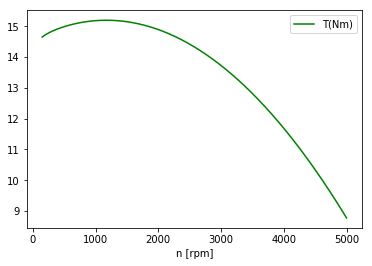

In [13]:
rpm=np.linspace(150,5000,2000)
P=(-0.00000004564538677*(rpm**3))+(0.0001056995459*(rpm**2))+(1.53209191*rpm)-1.895523696
T=P/(rpm*np.pi/30)
plt.plot(rpm,T, 'g', label='T(Nm)')
plt.legend(loc='best')
plt.xlabel('n [rpm]')

Es importante aclarar que para rpm entre 0 a 150 el torque se definio como constante y su valor es de 14,65 Nm y el torque esta restringido por las rpm maximos del motor que son 5000. A partir de esto la funcion omega a partir de la velocidad lineal calcula la velocidad angular del motor y la funcion torqueMotor tiene como parametro el resultado de la funcion omega y calcula el torque del motor:

In [5]:
def omega(vx,rx,Ncx):
    om=(vx/rx)*Ncx
    return (om)

In [6]:
def torqueMotor(omega):
    if ((omega*30)/np.pi)<=150:
        T=14.65
    if ((omega*30)/np.pi)>=5000:
        rpm=5000
        P=(-0.00000004564538677*(rpm**3))+(0.0001056995459*(rpm**2))+(1.53209191*rpm)-1.895523696
        T=P/(rpm*np.pi/30)
    else:
        rpm=(omega*30)/np.pi
        P=(-0.00000004564538677*(rpm**3))+(0.0001056995459*(rpm**2))+(1.53209191*rpm)-1.895523696
        T=P/(rpm*np.pi/30)
    return (T)

La siguiente funcion calcula la masa equivalente de los elementos rotativos:

In [8]:
def Masaequi(Iwx,Idx,Iex,Ncx,rx):
    Me=((Iwx+Idx)+(Iex*(Ncx**2)))/(rx**2)
    return (Me)

Tanto la funcion 1 como 2 son de orden 2 por lo que para poder utilizar odeint es necesario definir las funciones como:

$x'=v$

$v'=a$

donde a es igual a:

$a=\frac{\frac{T N_c \eta_t}{r} - R_x - D_A}{(M+M_r)}$

y T puede ser $T_e$ o $T_f$

Con esto claro se tiene que:

#### Aceleracion:

In [9]:
def funa(y,t,rhox,afx,cdx,rejex,Ncx,wx,Iwx,Idx,Iex,rx,efix):
    dist, vel=y
    #torqueMotor(omega(vel,rx,Ncx))
    acel=(((torqueMotor(omega(vel,rx,Ncx))*Ncx*efix)/rx)-frodadura_const(vel,wx)-farrastre(vel,rhox,afx,cdx))/((wx/9.81)+Masaequi(Iwx,Idx,Iex,Ncx,rx))
    dydt=[vel,acel]
    return dydt

#### Frenado:

In [10]:
def funf(y,t,rhox,afx,cdx,rejex,Ncx,wx,Iwx,Idx,Iex,rx,efix):
    dist, vel=y
    #torquedefrenos=cte=10 Nm
    acel=((-2*Ncx*efix/rx)-frodadura_const(vel,wx)-farrastre(vel,rhox,afx,cdx))/((wx/9.81)+Masaequi(Iwx,Idx,Iex,Ncx,rx))
    dydt=[vel,acel]
    return dydt

In [7]:
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
reje=0.02 # Radio eje de las llantas (m)
efi=0.95 # Eficiencia de transmisión
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)
Ie=5.2E-3 # Inercia motor(kg m^2) 
mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
rin=0.0631 #radio interno del neumático (m)
rll=0.139 # Radio geométrico de las llantas en traseras (m)
r=0.98*rll # Radio efectivo llantas traseras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
Iw=2*illd+2*illt
meje=3.832 # Masa del eje (kg)
Id=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)


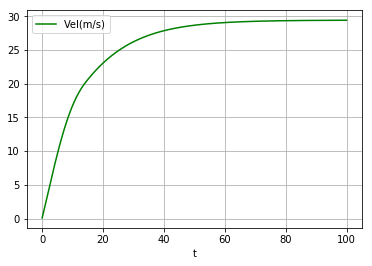

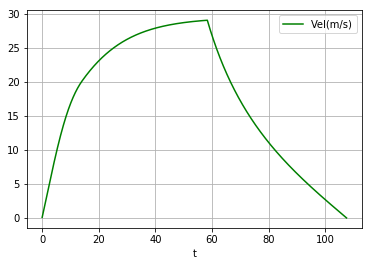

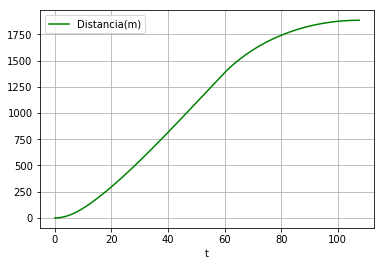

El tiempo que se demoro fue:  107.547547548 s
La distancia que recorrio fue:  1884.43373388 m


In [21]:
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión

y0=[0.0,0.1]
t0 = np.linspace(0,100,1000)
sol0 = odeint(funa, y0, t0,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))

modelo=[]
i=0
while sol0[i+1,1]-sol0[i,1]>0.003:
    modelo.append([t0[i],sol0[i,0],sol0[i,1]])
    i=i+1
tVmax=modelo[-1][0]
disVmax=modelo[-1][1]
Vmax=modelo[-1][2]

y1=[0,Vmax]
t1 = np.linspace(0, 70, 1000)
sol1 = odeint(funf, y1, t1,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))

j=0
while sol1[j,1]>=0:
    modelo.append([tVmax+t1[j],disVmax+sol1[j,0],sol1[j,1]])
    j=j+1

mod=np.array(modelo)

figure()
plt.plot(t0,sol0[:,1], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

figure()
plt.plot(mod[:,0],mod[:,2], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

figure()
plt.plot(mod[:,0],mod[:,1], 'g', label='Distancia(m)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
print('El tiempo que se demoro fue: ',mod[-1,0],'s')
print('La distancia que recorrio fue: ',mod[-1,1],'m')

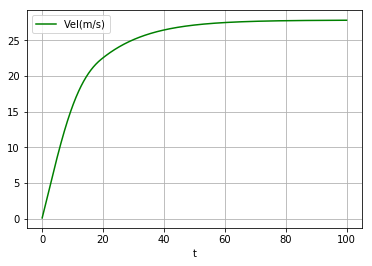

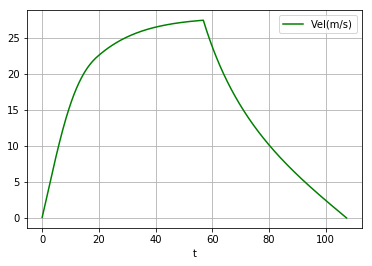

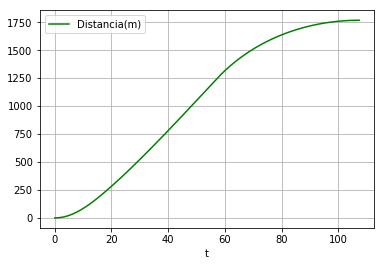

El tiempo que se demoro fue:  107.377377377 s
La distancia que recorrio fue:  1767.89632499 m


In [22]:
dp=20.0 # Dientes del piñon
dpl=64.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión

y0=[0.0,0.1]
t0 = np.linspace(0,100,1000)
sol0 = odeint(funa, y0, t0,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))

modelo=[]
i=0
while sol0[i+1,1]-sol0[i,1]>0.003:
    modelo.append([t0[i],sol0[i,0],sol0[i,1]])
    i=i+1
tVmax=modelo[-1][0]
disVmax=modelo[-1][1]
Vmax=modelo[-1][2]

y1=[0,Vmax]
t1 = np.linspace(0, 70, 1000)
sol1 = odeint(funf, y1, t1,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))

j=0
while sol1[j,1]>=0:
    modelo.append([tVmax+t1[j],disVmax+sol1[j,0],sol1[j,1]])
    j=j+1

mod=np.array(modelo)

figure()
plt.plot(t0,sol0[:,1], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

figure()
plt.plot(mod[:,0],mod[:,2], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

figure()
plt.plot(mod[:,0],mod[:,1], 'g', label='Distancia(m)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
print('El tiempo que se demoro fue: ',mod[-1,0],'s')
print('La distancia que recorrio fue: ',mod[-1,1],'m')

Vmax=20
modelo=[]
i=0
while sol0[i,1]<=Vmax:
    modelo.append([t0[i],sol0[i,0],sol0[i,1]])
    i=i+1
tVmax=modelo[i-1][0]
disVmax=modelo[i-1][1]
j=0
while sol1[j,1]>=0:
    modelo.append([tVmax+t1[j],disVmax+sol1[j,0],sol1[j,1]])
    j=j+1

mod=np.array(modelo)
figure()
plt.plot(mod[:,0],mod[:,2], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
figure()
plt.plot(mod[:,0],mod[:,1], 'g', label='Distancia(m)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
print('El tiempo que se demoro fue: ',mod[-1,0],'s')
print('La distancia que recorrio fue: ',mod[-1,1],'m')